# Подготовка к первому компьютерному коллоквиуму
Дан набор данных о сотрудниках. Цель - создать модель линейной регрессии, которая, основываясь на данных из файла data/train.csv, предсказывает зарплату.

В качестве метрики в задачах использовать *RMSE*, если не указано обратное.

Используйте уровень доверия 95% для всех статистических тестов, если не указано обратное.

**Задача 1.** <br>
Создайте модель линейной регрессии, используя все атрибуты.  
Выведите метрику, которую достигает модель.  

**Задача 3.** <br>
Усовершенствовать модель так, чтобы все предположения были выполнены и значение RMSE было меньше `11 170`. Использовать разделение на *train/val* в соотношении: *80/20*. Вывести показатель, который достигает модель.

*Примечание: использовать `random state = 42` (чтобы результаты можно было воспроизвести).*

In [5]:
from sklearn.model_selection import train_test_split

from utils_nans1 import *


def print_sums(model, x_train, y_train, x_val, y_val, df_train, plot=False):
    print(model.summary())
    print("Tests:")
    print(linear_assumption(model, sm.add_constant(x_train), y_train, plot=plot))
    print(independence_of_errors_assumption(model, sm.add_constant(x_train), y_train, plot=plot))
    print(normality_of_errors_assumption(model, sm.add_constant(x_train), y_train, plot=plot))
    print(equal_variance_assumption(model, sm.add_constant(x_train), y_train, plot=plot))
    print(perfect_collinearity_assumption(sm.add_constant(x_train), plot=plot))
    print("Metrics(val data):", get_rmse(model, x_val, y_val))
    pass


alpha = 0.05
rand_state = 42
train_part = 0.8

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")


plata               0
zvanje             59
oblast              0
godina_doktor      44
godina_iskustva     0
pol Zenski          0
pol Muski           0
dtype: int64
                            OLS Regression Results                            
Dep. Variable:                  plata   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     35.25
Date:                Fri, 08 Dec 2023   Prob (F-statistic):           9.95e-27
Time:                        21:06:28   Log-Likelihood:                -2695.3
No. Observations:                 237   AIC:                             5403.
Df Residuals:                     231   BIC:                             5423.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err      

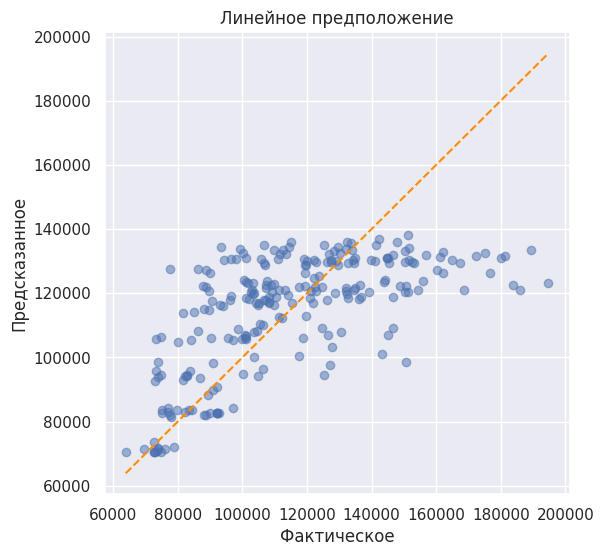

(True, 3.391612452681461e-27)


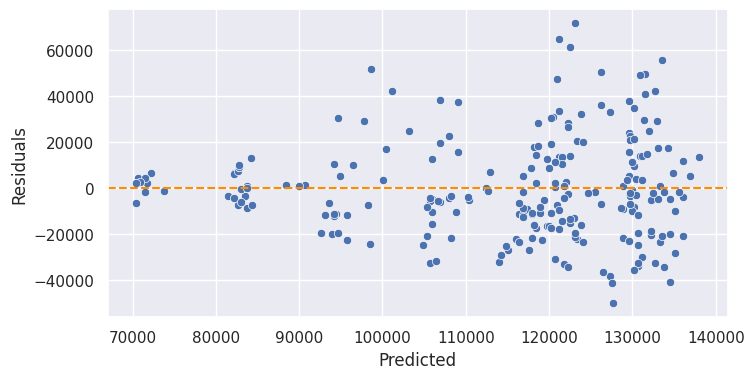

(None, 1.8747315371863467)


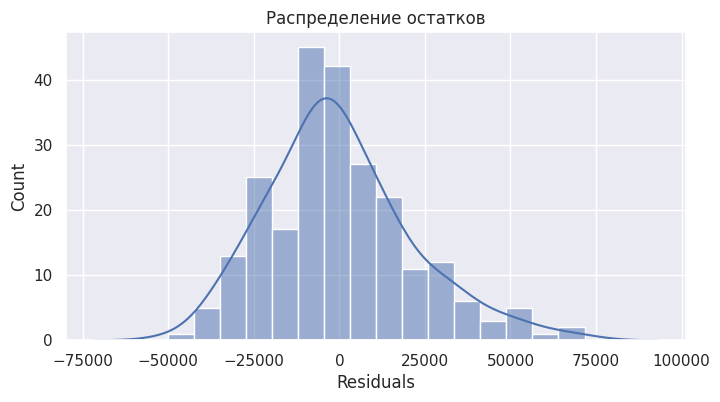

('non-normal', 0.0005602794527294162)


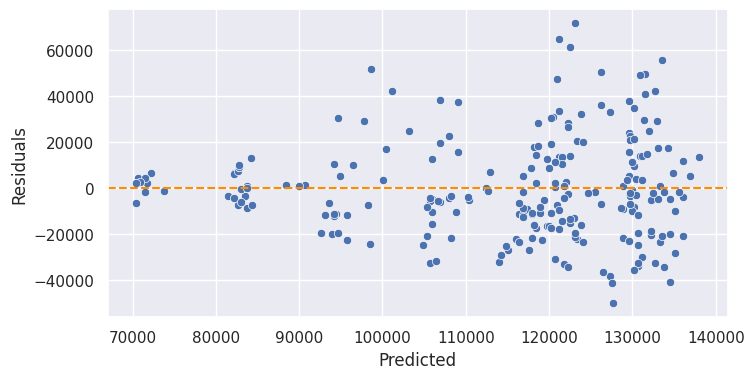

('equal', 0.9984497167394818)


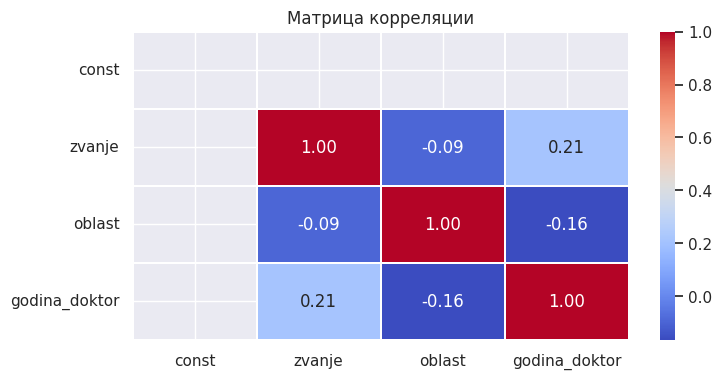

False
Metrics(val data): 21879.486372240033
Test data metrics: 10248.639474708509


In [6]:
# №1 and №3
# check nans
print(df_train.isna().sum())

# fixing train NANs
df_train = df_train.interpolate(method='spline', order=3, limit_direction='both')
df_train = df_train.round(0)

# build model
x_train = df_train.drop(columns=['plata'])
y_train = df_train['plata']

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  train_size=train_part, shuffle=True, random_state=rand_state)

model = get_fitted_model(x_train, y_train)
print(model.summary())
print_sums(model, x_train, y_train, x_val, y_val, df_train, plot=False)

# drop 'pol Zenski' because of collinearity with 'pol Muski'
# drop 'godina_iskustva' because p_value > p_treshhold
x_train = x_train.drop(columns=['godina_iskustva', 'pol Zenski'])
x_val = x_val.drop(columns=['godina_iskustva', 'pol Zenski'])

# then recreate and check
model = get_fitted_model(x_train, y_train)
print_sums(model, x_train, y_train, x_val, y_val, df_train, plot=False)
# check on test data
x_test = df_test.drop(columns=['plata', 'pol Zenski', 'godina_iskustva'])
y_test = df_test['plata']
print("Test data metrics:", get_rmse(model, x_test, y_test))

# drop 'pol Muski' because p_value > p_treshhold
x_train = x_train.drop(columns=['pol Muski'])
x_val = x_val.drop(columns=['pol Muski'])
# then recreate and check
model = get_fitted_model(x_train, y_train)
print_sums(model, x_train, y_train, x_val, y_val, df_train, plot=True)
# check on test data
x_test = df_test.drop(columns=['plata', 'pol Zenski', 'godina_iskustva', 'pol Muski'])
y_test = df_test['plata']
print("Test data metrics:", get_rmse(model, x_test, y_test))

**Задача 2.** <br>
Когда сотрудник получает повышение (например, переходит с позиции 1 на позицию 2), какое минимальное и максимальное увеличение заработной платы он ожидает?
Объясните, являются ли найденные значения допустимыми.

In [7]:
min_raise, max_raise = get_conf_interval(model, 'zvanje', alpha)
print(f"\nMin: {min_raise:.2f}")
print(f"Max: {max_raise:.2f}")
if normality_of_errors_assumption(model, sm.add_constant(x_train), y_train, plot=False)[0] == 'non-normal':
    print("Results are non-valid")
else:
    print("Results are valid")
print()


Min: 18200.55
Max: 25838.11
Results are non-valid


**Задача 4.** <br>
Существует ли хотя бы одна независимая переменная, линейно связанная с зарплатой? Обоснуйте ваш ответ.

In [8]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  plata   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     55.74
Date:                Fri, 08 Dec 2023   Prob (F-statistic):           3.39e-27
Time:                        21:06:30   Log-Likelihood:                -2698.4
No. Observations:                 237   AIC:                             5405.
Df Residuals:                     233   BIC:                             5419.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           4.77e+04   5362.774      8.895

Due to the "Prob (F-statistic): 3.39e-27" < 0.05 then 95% that there is liner dependence between dependent variable and any other independent variable

**Задача 5.** <br>
Объясните меру скорректированного $r^2$.

R-squared (R²) is a measure used in regression analysis to assess the proportion of the variance in the dependent variable explained by the model. However, in some cases, R² may be distorted due to the presence of a large number of predictors (independent variables) that do not contribute significantly to explaining the variability of the dependent variable.

Measures like adjusted R² are designed to account for this distortion. Adjusted R² incorporates a correction that takes into consideration the number of predictors in the model and aims to strike a balance between the model's accuracy and its complexity.

The formula for adjusted R² is as follows:

$ R_{\text{adj}}^2 = 1 - \frac{(1 - R^2) \cdot (n - 1)}{(n - k - 1)} $

where:
- $ R_{\text{adj}}^2 $ - adjusted R².
- $ R^2 $ - regular R².
- $ n $ - the number of observations (sample size).
- $ k $ - the number of predictors (independent variables) in the model.

The essence of this correction is to reduce the value of R² when the number of predictors in the model increases. This helps avoid undue optimism in the interpretation of R², which can occur when adding new predictors that do not make a substantial contribution to explaining the variability of the dependent variable.